In [1]:
# test the model
from util import *
from DSRN import *
from matplotlib import pyplot as plt
import torch
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

cwd = os.getcwd()

In [2]:
dataset = FaultData()
dataset.max , dataset.min = 11.6740, -10.0919
batch_size = 256
SNR = torch.tensor([-4,-3,-2,-1,0,1,2,3,4])
# csvpath = "/home/abdikhab/comp/Vib_data.csv"
# df, datalen= loadcsv(csvpath)
# dataset.prepare(df, datalen*2, ignore = [10,11,12])
# dataset.addnoise(SNR)
# train, test = dataset.split(batch_size,0.85)
# dataset.savett(train ,test)
train, test = dataset.loadtt()

data loaded


In [4]:
l = 0
for x ,y,z in test:
    l += x.shape[0]
print(l)

4260


In [3]:
#load the model from the checkpoint
# loading model 1000-88-0.99-7  was best result
imsize = 64
epochs = 100
# modelNoise1-88-1-5-8-40.pth was best with noise
lr, bt, th, ks,bl, wdec= 1e-3, 0.88,1, 5, 8, 0.004
iter = str(int(lr*1e6)) +'-'+ str(int(bt*100)) +'-'+ str(th) +'-'+ str(ks)
iter = "Noise" + str(int(lr*1e3)) +'-'+ str(int(bt*100)) +'-'+ str(th) +'-'+ str(ks) + '-'+ str(bl)
iter = "Noise" + str(int(lr*1e3)) +'-'+ str(int(bt*100)) +'-'+ str(th) +'-'+ str(ks) + '-'+ str(bl) + '-'+ str(int(wdec*10000))
print(f"loading model {iter}")
model = DSRN(nb_blocks=bl, in_ch=1, out_ch=8, imsize= [imsize,imsize], 
            device=device, betta = bt, thresh= th, kernelsize = ks).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999))
model.load_state_dict(torch.load(os.path.join(cwd,'model','Best_Res_Noise', f'model{iter}.pth')))
#model.load_state_dict(torch.load(os.path.join('/home/abdikhab/comp/Best80-23f', f'model{iter}.pth')))
leng = 0
test_losses = []
pred_results = torch.empty(0, device = device)
true_labels = torch.empty(0, device = device)
SNR_val =torch.empty(0, device = device)
with torch.no_grad():
    model.eval()
    for x, y, z in test:
        leng += x.shape[0]
        x = dataset.str2image(x, imsize, imsize)
        x = x.unsqueeze(1).to(device)
        outputs = model(x)
        _, predicted = torch.max(torch.sum(outputs, dim =0), 1)
        pred_results= torch.cat((pred_results,predicted), dim = 0)
        true_labels = torch.cat((true_labels, y.to(device)), dim = 0)
        SNR_val = torch.cat((SNR_val, z.to(device)), dim = 0)
        tests_loss = criterion(torch.sum(outputs, dim =0), y.to(device))
        test_losses.append(tests_loss.item())


loading model Noise1-88-1-5-8-40


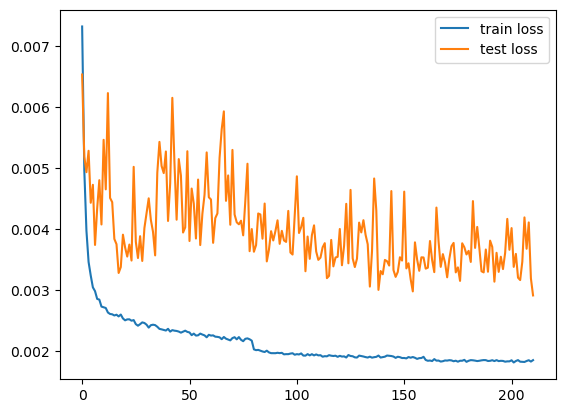

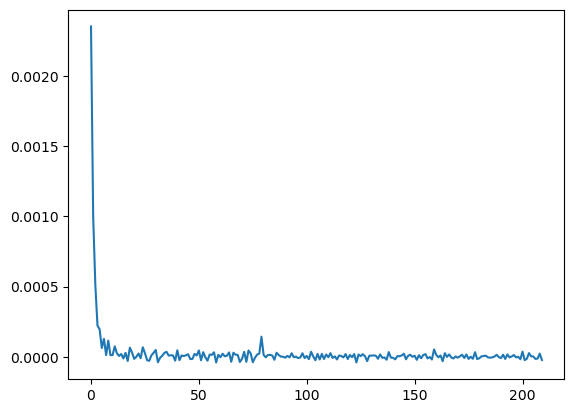

In [6]:
loss_ep = torch.load(os.path.join(cwd,'model','Best_Res_Noise', f'loss{iter}.pth'))
loss_test = torch.load(os.path.join(cwd,'model','Best_Res_Noise', f'loss_test{iter}.pth'))
dl = torch.sub(torch.tensor(loss_ep[:-1]), torch.tensor(loss_ep[1:]))
plt.plot(loss_ep, label = 'train loss')
plt.plot(loss_test, label = 'test loss')

plt.legend()
plt.show()
plt.plot(dl, label = 'delta loss')

In [10]:
lossavg = sum(test_losses)/leng
lables_snr = [[] for i in range(10)]
results_snr = [[] for i in range(10)]
print('Test loss: {:.4f}'.format(lossavg))
m = 0
fp = torch.zeros(10, device = device)
for n, reslt in enumerate(pred_results):
    if reslt != true_labels[n]:
        print('False prediction: {} for {} SNR {}'.format(reslt, true_labels[n], SNR_val[n]))
        m += 1
        if SNR_val[n] == 100:
            clss = 0
        else:
            clss = int(SNR_val[n]) - SNR[0] +1
        fp[clss] += 1
    if SNR_val[n] == 100:
        lables_snr[0].append(true_labels[n].cpu())
        results_snr[0].append(reslt.cpu())
    else:
        clss = int(SNR_val[n]) - SNR[0] +1
        lables_snr[clss].append(true_labels[n].cpu())
        results_snr[clss].append(reslt.cpu())

print("total false predictions: {}".format(m))
print("false predictions per class: {}".format(fp))


Test loss: 0.0029
False prediction: 0.0 for 5.0 SNR -4.0
False prediction: 2.0 for 1.0 SNR -2.0
False prediction: 0.0 for 7.0 SNR 0.0
False prediction: 5.0 for 0.0 SNR 0.0
False prediction: 6.0 for 0.0 SNR -2.0
False prediction: 0.0 for 6.0 SNR -3.0
False prediction: 6.0 for 7.0 SNR 2.0
False prediction: 0.0 for 6.0 SNR -2.0
False prediction: 5.0 for 2.0 SNR 0.0
False prediction: 0.0 for 7.0 SNR 3.0
False prediction: 2.0 for 5.0 SNR 1.0
False prediction: 7.0 for 9.0 SNR -4.0
False prediction: 7.0 for 5.0 SNR 3.0
False prediction: 0.0 for 2.0 SNR -1.0
False prediction: 7.0 for 5.0 SNR -2.0
False prediction: 1.0 for 2.0 SNR -1.0
False prediction: 0.0 for 7.0 SNR 2.0
False prediction: 2.0 for 0.0 SNR -2.0
False prediction: 1.0 for 0.0 SNR -4.0
False prediction: 7.0 for 0.0 SNR -4.0
False prediction: 2.0 for 7.0 SNR -1.0
False prediction: 0.0 for 7.0 SNR 2.0
False prediction: 0.0 for 7.0 SNR -3.0
False prediction: 2.0 for 5.0 SNR -1.0
False prediction: 9.0 for 1.0 SNR -1.0
False prediction

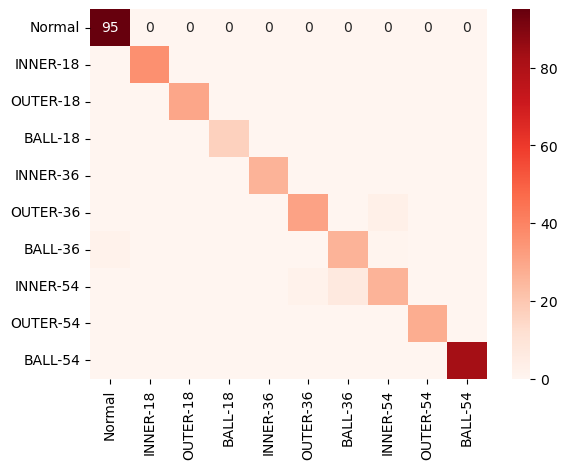

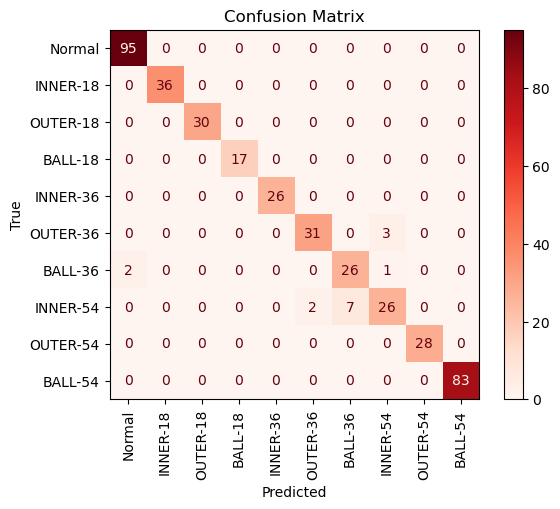

Accuracy:  96.3680387409201 %


In [17]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
ACC = []
for i in range(10):
    #print('Accuracy for SNR {}: {:.4f}'.format(SNR[i], accuracy_score(lables_snr[i], results_snr[i])*100, '%'))
    trlab = torch.stack(lables_snr[i]).cpu()
    predres = torch.stack(results_snr[i]).cpu()
    cm = confusion_matrix(trlab, predres)
    # Plot the confusion matrix
    classes = ["Normal", "INNER-18","OUTER-18","BALL-18","INNER-36","OUTER-36","BALL-36","INNER-54","OUTER-54","BALL-54"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=classes, yticklabels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
    disp.plot(cmap='Reds', values_format='d')
    plt.xticks(rotation='vertical')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    print('Accuracy: ', accuracy_score(trlab, predres)*100, '%')
    ACC.append(accuracy_score(trlab, predres)*100)
    break

In [13]:
cm

array([[95,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 36,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 30,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 17,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 26,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 31,  0,  3,  0,  0],
       [ 2,  0,  0,  0,  0,  0, 26,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  7, 26,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 28,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 83]])

<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_367542/525881115.py:14: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Accuracy \%')


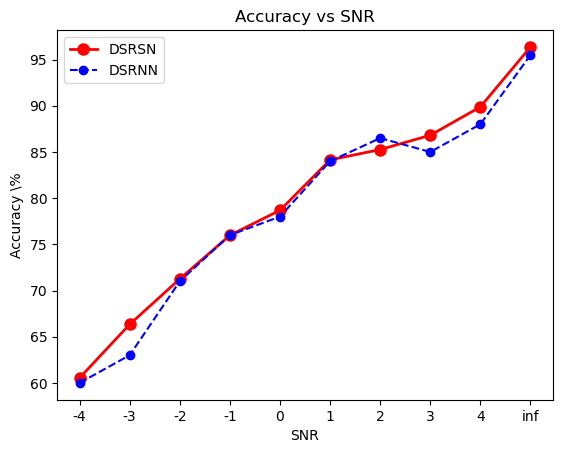

In [13]:
# Swap the first content of the list to the last content
SNR = torch.tensor([-4,-3,-2,-1,0,1,2,3,4])
x = SNR.cpu().numpy()
x = ['-4','-3','-2','-1','0','1','2','3','4', 'inf']

accuracymat = ACC[1:]
accuracymat.append(ACC[0])
#plot with the x value of the string
DSRNN = [60,63,71,76,78,84,86.5,85,88,95.5]

plt.plot(x, accuracymat, marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.plot(x, DSRNN, 'bo--')
plt.xlabel('SNR')
plt.ylabel('Accuracy \%')
plt.title('Accuracy vs SNR')
plt.legend(['DSRSN', 'DSRNN'])
torch.save(accuracymat, os.path.join(cwd,'model', f'accuracy{iter}.pth'))

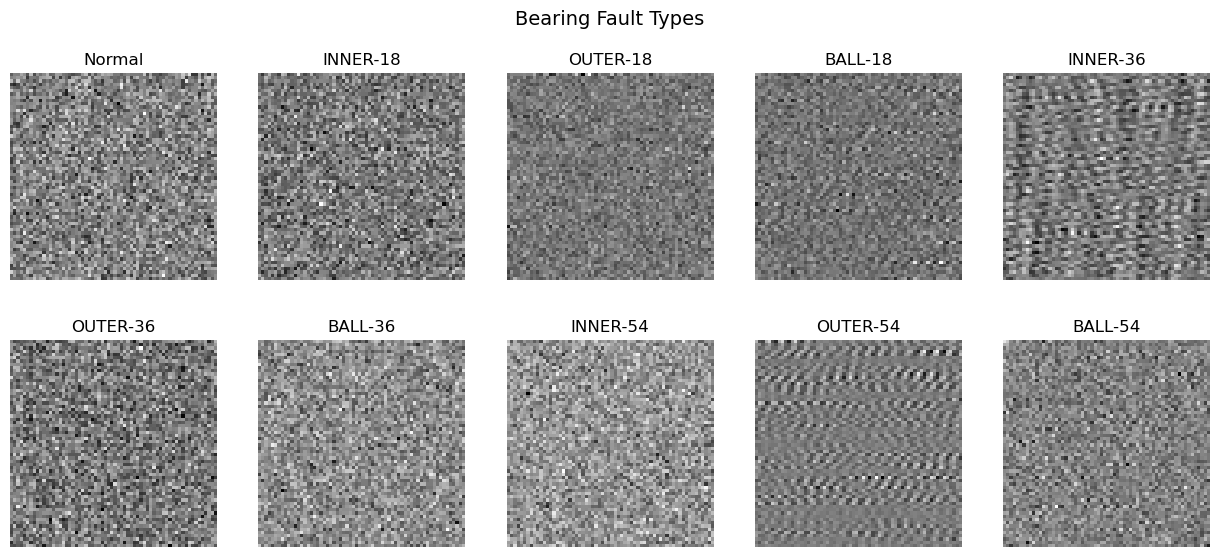

In [5]:
# plot 9 different fault types in one figure


# plt of 10 different subplots
dataset = FaultData()
dataset.max , dataset.min = 11.6740, -10.0919
fig, axs = plt.subplots(2, 5, figsize=(15, 15))
n = 0
i, j = 0, 0
titles = ["Normal", "INNER-18","OUTER-18","BALL-18","INNER-36","OUTER-36","BALL-36","INNER-54","OUTER-54","BALL-54"]
for xb, yb, z in test:
    xb = dataset.str2image(xb, 64, 64)
    for x , y in zip(torch.floor((xb* 255)), yb):
        if y == n:
            fig.suptitle('Bearing Fault Types', fontsize=14)
            axs[i,j].imshow(x.cpu(), cmap='gray')
            axs[i,j].axis('off')  # Turn off axis labels for better visibility
            axs[i,j].set_xticks([])  # Remove x-axis ticks
            axs[i,j].set_yticks([])
            axs[i,j].set_title(titles[n])  # Add titles
            n += 1
            j += 1
            if j == 5:
                j = 0
                i += 1
            if i == 2:
                i = 0
        if n > 9:
            break
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.61, top=0.95, wspace=0.2, hspace=0.1)

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# convert dataloader class objects to numpy array
train_x = torch.empty(0)
train_y = torch.empty(0)
device = torch.device("cpu")
model.eval().to(device)
l = 0
n = 0
for x, y, z in train:
    x = dataset.str2image(x, imsize, imsize)
    x = x.unsqueeze(1).to(device)
    outputs = model(x)
    l += x.shape[0]
    #x = dataset.str2image(x, 64, 64)
    sm = torch.sum(outputs, dim =0).cpu()
    _,tmp =torch.max(torch.sum(outputs, dim =0), 1)
    
    train_x = torch.cat((train_x,sm))
    train_y = torch.cat((train_y, y.cpu()))

train_x= train_x.detach().numpy()
train_y = train_y.detach().numpy()

In [18]:
# Perform PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(train_x)
tsne = TSNE(n_components=2, random_state=42)
# Fit and transform the data
X_tsne = tsne.fit_transform(train_x)

colors = ['red', 'green', 'blue', 'c', 'm', 'yellow', 'black', 'orange', 'purple', 'brown']
legend = ['Normal', 'INNER-18','OUTER-18','BALL-18','INNER-36','OUTER-36','BALL-36','INNER-54','OUTER-54','BALL-54']
# Plot the result
X_Class = [[] for i in range(10)]
Y_Class = [[] for i in range(10)]
Z_Class = [[] for i in range(10)]
X_TSNE = [[] for i in range(10)]
Y_TSNE = [[] for i in range(10)]
for xp, yp in zip(reduced_data, train_y):
    X_Class[int(yp)].append(xp[0])
    Y_Class[int(yp)].append(xp[1])
    # Z_Class[int(yp)].append(xp[2])
for xp, yp in zip(X_tsne, train_y):
    X_TSNE[int(yp)].append(xp[0])
    Y_TSNE[int(yp)].append(xp[1])
    # Z_Class[int(yp)].append(xp[2])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)# projection='3d')
for i in range(10):
    ax.scatter(X_TSNE[i],Y_TSNE[i], c=colors[i], label = legend[i])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
#ax.set_zlabel('Principal Component 3')

plt.title('Dimensionality Reduction using TSNE')
plt.legend(loc='upper right')
plt.show()


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)# projection='3d')
for i in range(10):
    ax.scatter(X_Class[i],Y_Class[i], c=colors[i], label = legend[i])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
#ax.set_zlabel('Principal Component 3')

plt.title('Dimensionality Reduction using PCA')
plt.legend(loc='upper right')
plt.show()

NameError: name 'PCA' is not defined

In [12]:
z.shape

torch.Size([76])